# Algorithm Implementation: Linear Regression

## Overview
Implementation of Linear Regression to model life expectancy based on development indicators. This algorithm helps us understand how different socio-economic and environmental factors contribute to health outcomes through a linear relationship framework, providing interpretable coefficients that directly measure the impact of each factor.

## Objectives
- Model life expectancy using multiple development indicators
- Quantify the impact of each factor on health outcomes
- Analyze interactions between economic and environmental variables
- Provide interpretable insights for policy decisions

## Key Questions
1. How do economic indicators (GDP, debt) influence life expectancy?
2. What is the relationship between environmental impact (GHG emissions) and health outcomes?
3. How do labor force participation and military expenditure affect life expectancy?

In [ ]:
# Import required libraries
import wbdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from scipy import stats
import warnings

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualizations
sns.set_palette('husl')
%matplotlib inline

## Data Collection and Preprocessing

### 1. Data Collection
We'll fetch data from the World Bank's World Development Indicators database using the `wbdata` package.

In [ ]:
# Define indicators
indicators = {
    "NY.GDP.PCAP.CD": "GDP per capita",
    "SP.DYN.LE00.IN": "Life Expectancy",
    "EN.GHG.ALL.MT.CE.AR5": "Total GHG Emissions",
    "SP.POP.TOTL": "Population",
    "SL.TLF.CACT.ZS": "Labor Force Participation",
    "MS.MIL.XPND.GD.ZS": "Military Expenditure",
    "DT.TDS.DPPF.XP.ZS": "Debt Service"
}

def fetch_data():
    print("Fetching data from World Bank...")
    data = {}
    for indicator in indicators.keys():
        print(f"Fetching {indicators[indicator]}...")
        result = wbdata.get_data(indicator)
        data[indicators[indicator]] = result
        
    # Convert to DataFrame
    print("\nProcessing data...")
    rows = []
    for indicator_name, indicator_data in data.items():
        for entry in indicator_data:
            if entry['value'] is not None:
                rows.append({
                    'country': entry['country']['value'],
                    'year': entry['date'],
                    'indicator': indicator_name,
                    'value': float(entry['value'])
                })
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    
    # Pivot and process
    df = df.pivot_table(
        index=['country', 'year'],
        columns='indicator',
        values='value'
    ).reset_index()
    
    # Sort and compute derived metrics
    df['year'] = pd.to_numeric(df['year'])
    df = df.sort_values('year', ascending=False)
    df["GHG Emissions per Capita"] = (df["Total GHG Emissions"] * 1_000_000) / df["Population"]
    df = df.drop(columns=["Total GHG Emissions", "Population"])
    
    return df

# Fetch the data
df = fetch_data()

### 2. Data Preprocessing
We'll clean the data, handle missing values, and prepare it for linear regression analysis.

In [3]:
def preprocess_data(df):
    # Take most recent year's data for each country
    df_recent = df.sort_values('year', ascending=False).groupby('country').first().reset_index()
    
    # Log transform GDP and GHG emissions
    df_recent['GDP per capita (log)'] = np.log(df_recent['GDP per capita'])
    df_recent['GHG Emissions per Capita (log)'] = np.log(df_recent['GHG Emissions per Capita'])
    
    # Handle missing values
    numeric_columns = df_recent.select_dtypes(include=[np.number]).columns
    df_recent[numeric_columns] = df_recent[numeric_columns].fillna(df_recent[numeric_columns].mean())
    
    # Remove outliers using IQR method
    Q1 = df_recent['Life Expectancy'].quantile(0.25)
    Q3 = df_recent['Life Expectancy'].quantile(0.75)
    IQR = Q3 - Q1
    df_clean = df_recent[
        (df_recent['Life Expectancy'] >= Q1 - 1.5 * IQR) &
        (df_recent['Life Expectancy'] <= Q3 + 1.5 * IQR)
    ]
    
    return df_clean

# Preprocess the data
df_processed = preprocess_data(df)

# Display basic information about the processed dataset
print("\nProcessed Dataset Info:")
print(df_processed.info())

print("\nSample of processed data:")
print(df_processed.head())


Processed Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   country                         265 non-null    object 
 1   year                            265 non-null    int64  
 2   Debt Service                    265 non-null    float64
 3   GDP per capita                  265 non-null    float64
 4   Labor Force Participation       265 non-null    float64
 5   Life Expectancy                 265 non-null    float64
 6   Military Expenditure            265 non-null    float64
 7   GHG Emissions per Capita        265 non-null    float64
 8   GDP per capita (log)            265 non-null    float64
 9   GHG Emissions per Capita (log)  265 non-null    float64
dtypes: float64(8), int64(1), object(1)
memory usage: 20.8+ KB
None

Sample of processed data:
indicator                      country  yea

## Exploratory Data Analysis

### 1. Feature Analysis and Visualization

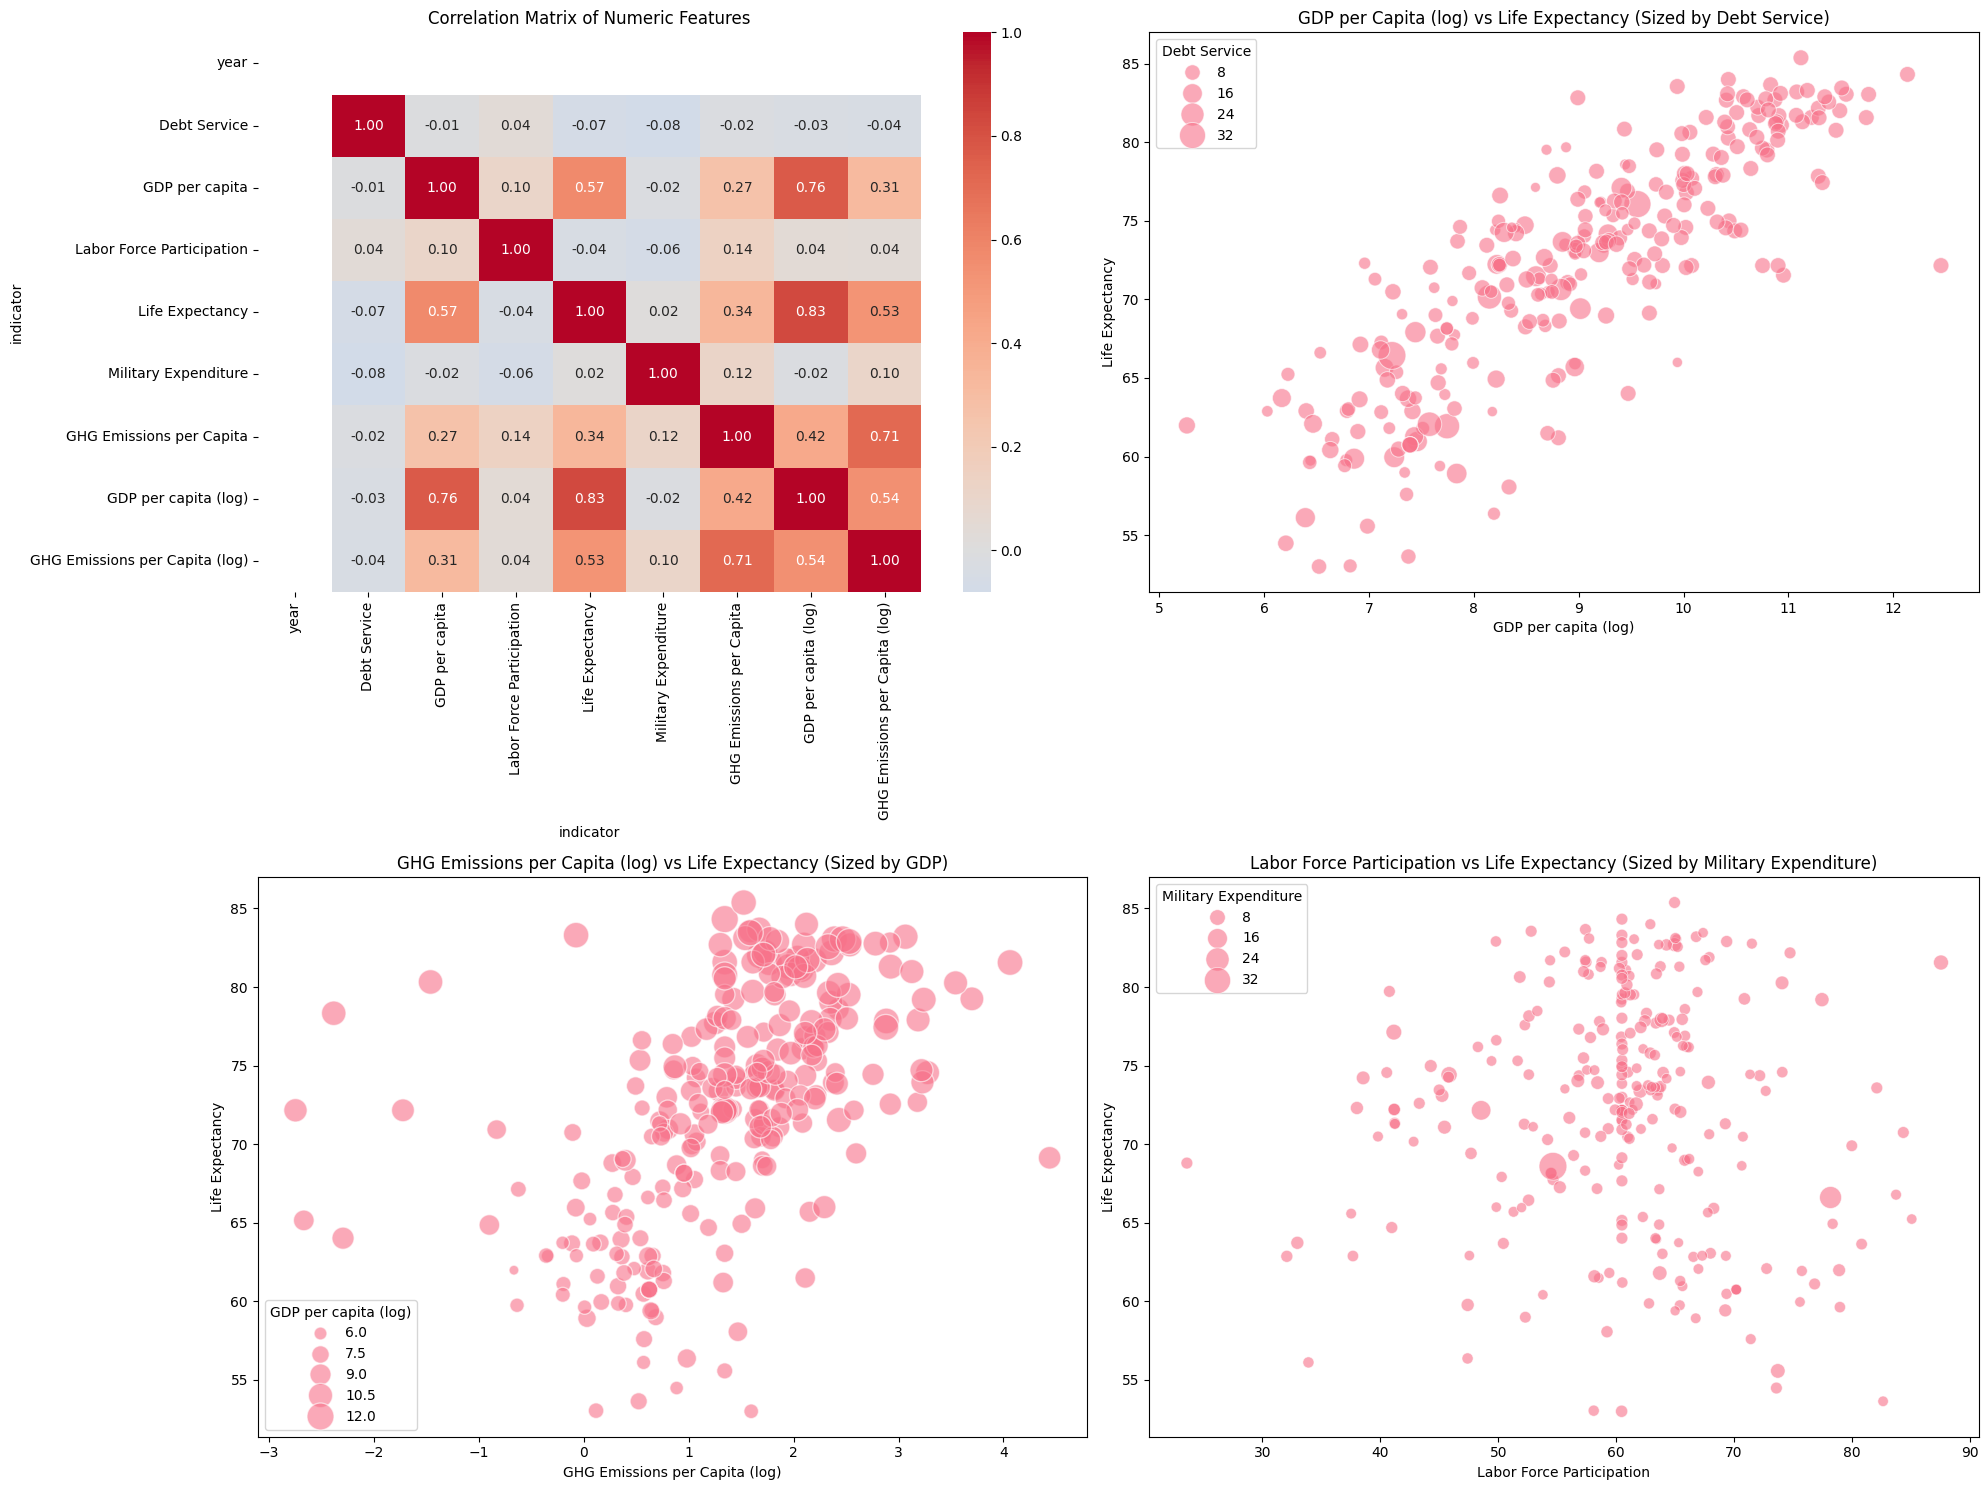

In [12]:
def plot_exploratory_analysis(df):
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Correlation Heatmap
    plt.subplot(2, 2, 1)
    correlation_matrix = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Matrix of Numeric Features')
    
    # 2. GDP vs Life Expectancy (Key Question 1: Economic Indicators)
    plt.subplot(2, 2, 2)
    sns.scatterplot(
        data=df,
        x='GDP per capita (log)',
        y='Life Expectancy',
        size='Debt Service',
        sizes=(50, 400),
        alpha=0.6
    )
    plt.title('GDP per Capita (log) vs Life Expectancy (Sized by Debt Service)')
    
    # 3. CO2 Emissions vs Life Expectancy (Key Question 2: Environmental Impact)
    plt.subplot(2, 2, 3)
    sns.scatterplot(
        data=df,
        x='GHG Emissions per Capita (log)',
        y='Life Expectancy',
        size='GDP per capita (log)',
        sizes=(50, 400),
        alpha=0.6
    )
    plt.title('GHG Emissions per Capita (log) vs Life Expectancy (Sized by GDP)')
    
    # 4. Labor Force Participation vs Life Expectancy (Key Question 3)
    plt.subplot(2, 2, 4)
    sns.scatterplot(
        data=df,
        x='Labor Force Participation',
        y='Life Expectancy',
        size='Military Expenditure',
        sizes=(50, 400),
        alpha=0.6
    )
    plt.title('Labor Force Participation vs Life Expectancy (Sized by Military Expenditure)')
     # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Plot exploratory analysis
plot_exploratory_analysis(df_processed)


## Model Implementation

### 1. Basic Linear Regression

In [13]:
# Prepare features and target
features = ['GDP per capita (log)', 'GHG Emissions per Capita (log)', 
           'Labor Force Participation', 'Military Expenditure', 'Debt Service']
X = df_processed[features]
y = df_processed['Life Expectancy']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create and fit pipeline
basic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

basic_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_train = basic_pipeline.predict(X_train)
y_pred_test = basic_pipeline.predict(X_test)

# Print performance metrics
print("Training Performance:")
print(f"R² Score: {r2_score(y_train, y_pred_train):.4f}")
print(f"MSE: {mean_squared_error(y_train, y_pred_train):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.4f}")

print("\nTest Performance:")
print(f"R² Score: {r2_score(y_test, y_pred_test):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.4f}")

# Print feature coefficients
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': basic_pipeline.named_steps['regressor'].coef_
})
print("\nFeature Coefficients:")
print(coefficients.sort_values('Coefficient', ascending=False))

Training Performance:
R² Score: 0.6849
MSE: 17.1372
RMSE: 4.1397
MAE: 3.1203

Test Performance:
R² Score: 0.7902
MSE: 11.2351
RMSE: 3.3519
MAE: 2.8087

Feature Coefficients:
                          Feature  Coefficient
0            GDP per capita (log)     5.687060
1  GHG Emissions per Capita (log)     0.642218
3            Military Expenditure     0.151432
4                    Debt Service    -0.362452
2       Labor Force Participation    -0.549847


### 2. Advanced Implementation with Polynomial Features

In [14]:
# Create and fit advanced pipeline with polynomial features
advanced_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

advanced_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_train_adv = advanced_pipeline.predict(X_train)
y_pred_test_adv = advanced_pipeline.predict(X_test)

# Print performance metrics
print("Advanced Model - Training Performance:")
print(f"R² Score: {r2_score(y_train, y_pred_train_adv):.4f}")
print(f"MSE: {mean_squared_error(y_train, y_pred_train_adv):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_adv)):.4f}")

print("\nAdvanced Model - Test Performance:")
print(f"R² Score: {r2_score(y_test, y_pred_test_adv):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test_adv):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_adv)):.4f}")

Advanced Model - Training Performance:
R² Score: 0.7222
MSE: 15.1041
RMSE: 3.8864

Advanced Model - Test Performance:
R² Score: 0.7327
MSE: 14.3161
RMSE: 3.7837


## Model Diagnostics

### 1. Residual Analysis

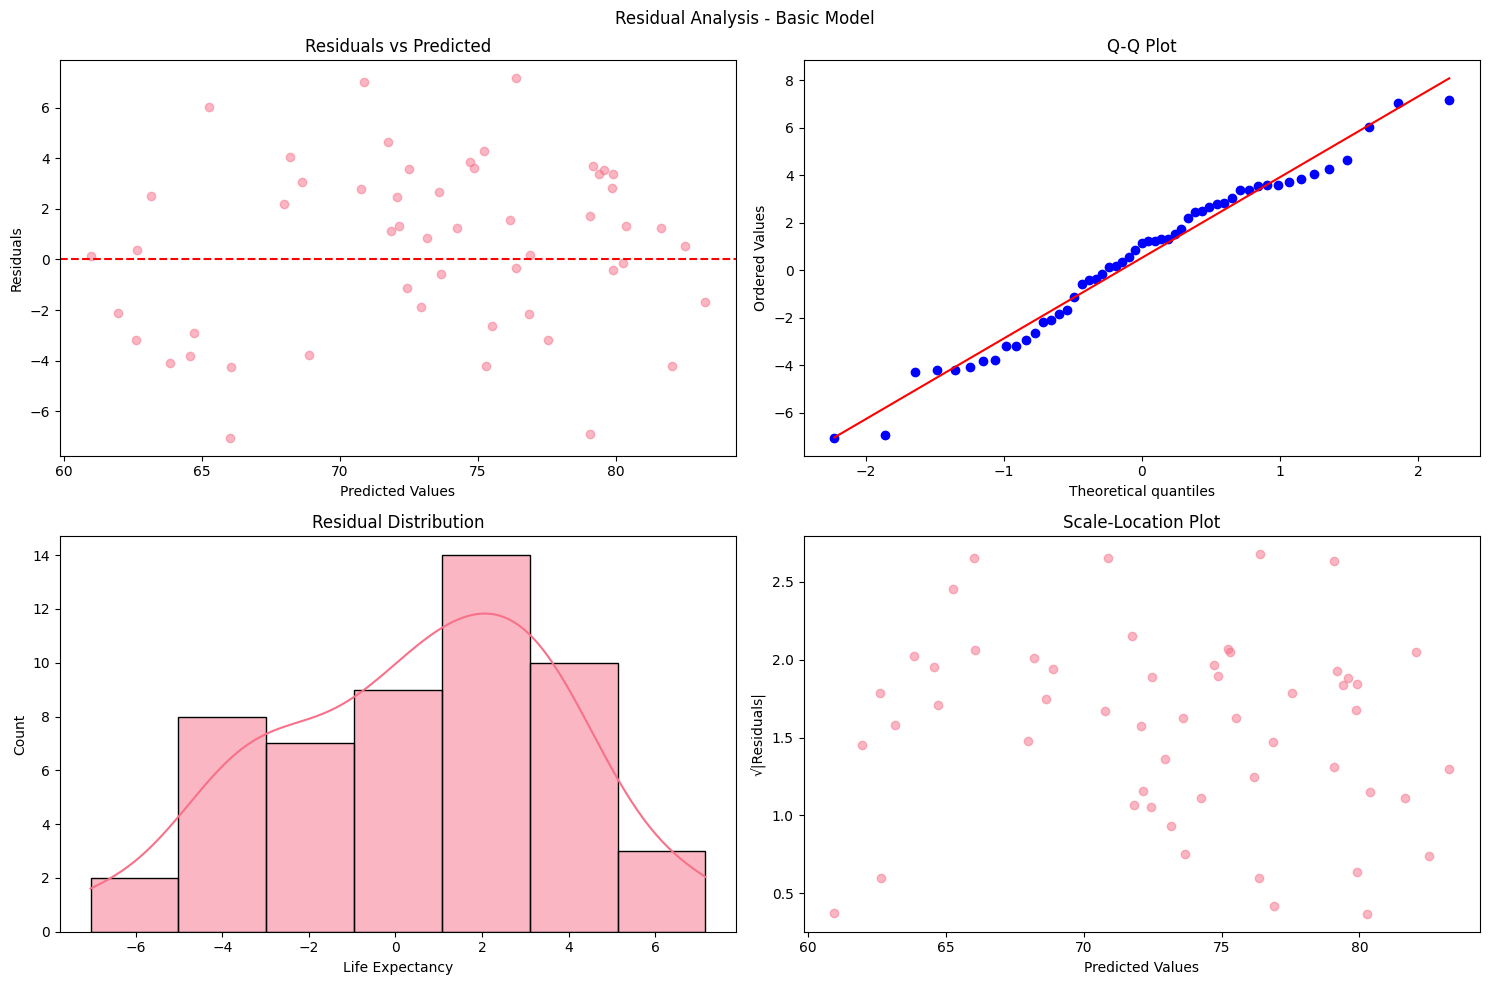

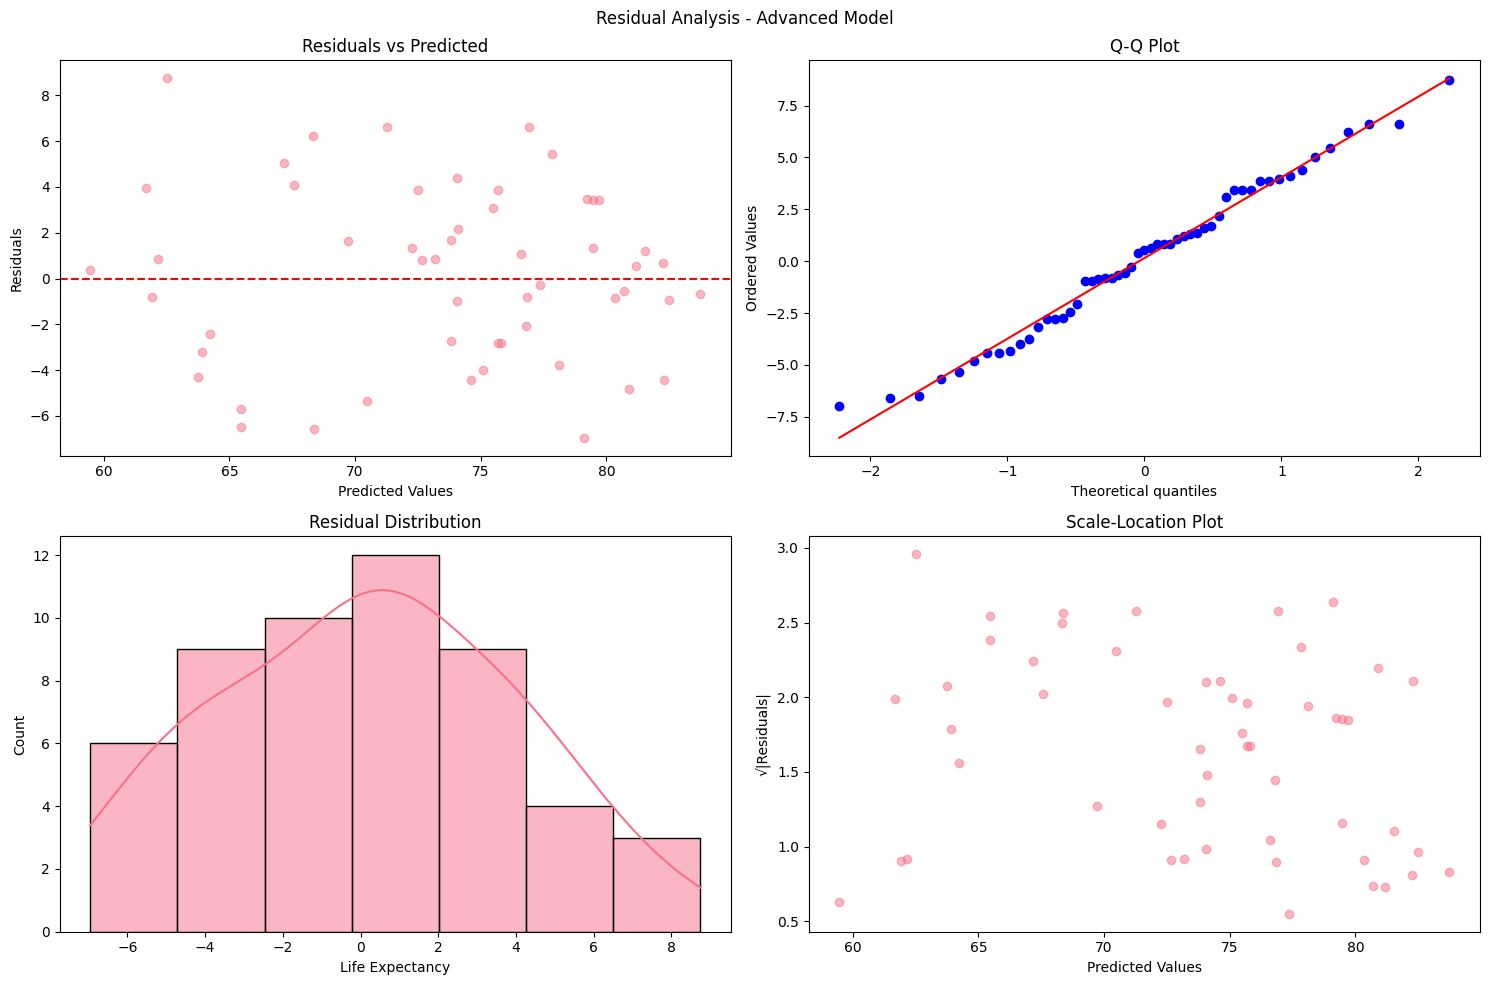

In [15]:
def plot_residual_analysis(y_true, y_pred, title):
    residuals = y_true - y_pred
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Residual Analysis - {title}')
    
    # 1. Residuals vs Predicted
    axes[0, 0].scatter(y_pred, residuals, alpha=0.5)
    axes[0, 0].axhline(y=0, color='r', linestyle='--')
    axes[0, 0].set_xlabel('Predicted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Predicted')
    
    # 2. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot')
    
    # 3. Residual Distribution
    sns.histplot(residuals, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Residual Distribution')
    
    # 4. Scale-Location Plot
    axes[1, 1].scatter(y_pred, np.sqrt(np.abs(residuals)), alpha=0.5)
    axes[1, 1].set_xlabel('Predicted Values')
    axes[1, 1].set_ylabel('√|Residuals|')
    axes[1, 1].set_title('Scale-Location Plot')
    
    plt.tight_layout()
    plt.show()

# Plot residual analysis for both models
plot_residual_analysis(y_test, y_pred_test, "Basic Model")
plot_residual_analysis(y_test, y_pred_test_adv, "Advanced Model")

## Results and Interpretation

### 1. Model Comparison

In [20]:
def compare_models(X, y):
    models = {
        'Basic': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ]),
        'Advanced': Pipeline([
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ]),
        'Ridge': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Ridge(alpha=1.0))
        ])
    }
    
    results = pd.DataFrame(columns=['Model', 'Mean R²', 'Std R²'])
    results_list = []  # Temporary list to store results
    
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=5, scoring='r2')
        results_list.append({
            'Model': name,
            'Mean R²': scores.mean(),
            'Std R²': scores.std()
        })
    
    # Concatenate all results at once
    results = pd.concat([results, pd.DataFrame(results_list)], ignore_index=True)
    
    return results


Model Comparison (5-fold CV):
      Model   Mean R²    Std R²
0     Basic  0.672926  0.095080
1  Advanced  0.639887  0.119757
2     Ridge  0.673258  0.094433


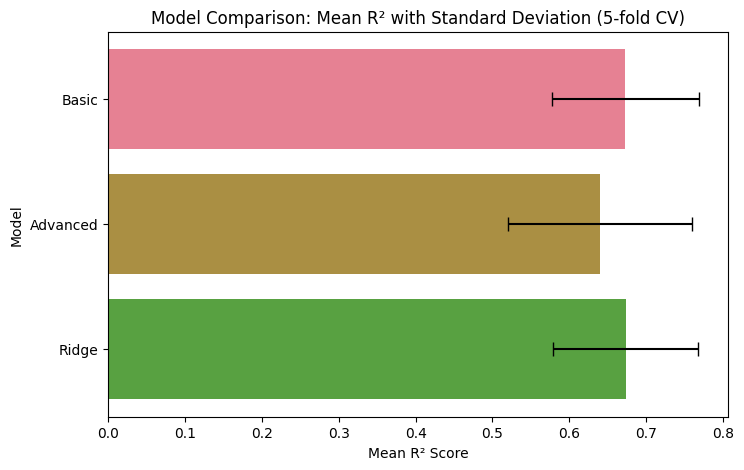


Feature Coefficients (Basic Model):
                          Feature  Coefficient
0            GDP per capita (log)     5.687060
1  GHG Emissions per Capita (log)     0.642218
2       Labor Force Participation    -0.549847
3            Military Expenditure     0.151432
4                    Debt Service    -0.362452


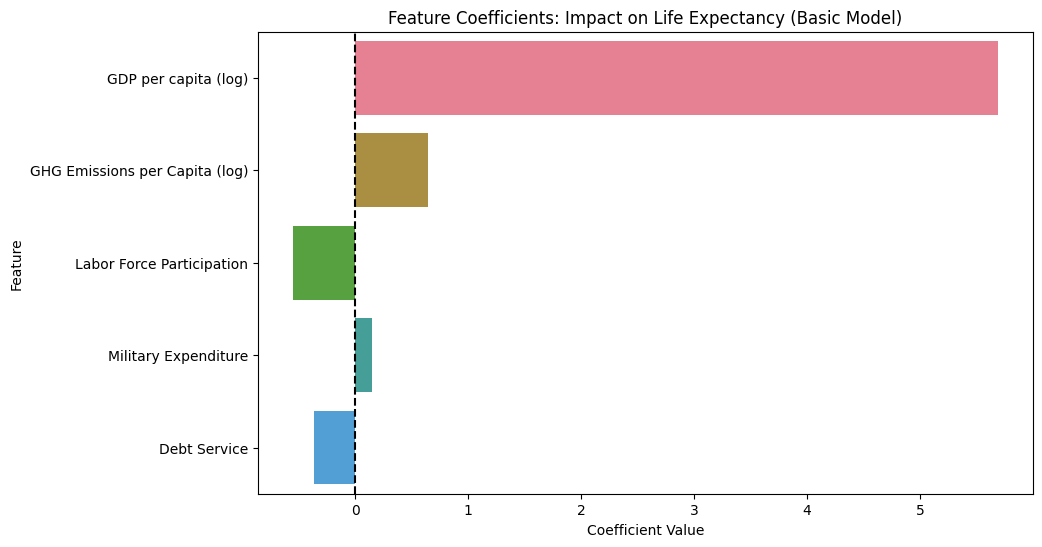

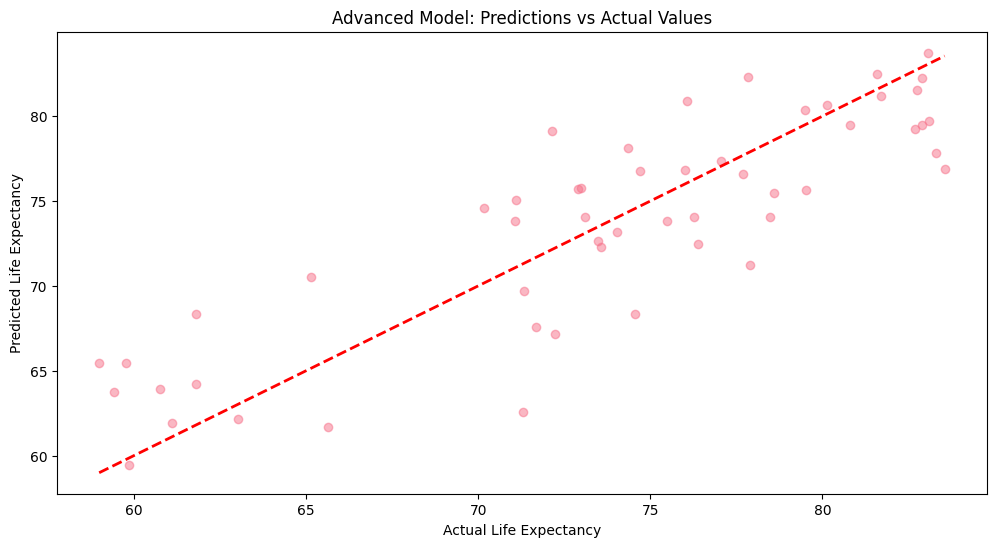

In [23]:
## Results and Interpretation

### 1. Model Comparison

# Compare models (already updated above)
comparison_results = compare_models(X, y)

# Display the comparison results
print("Model Comparison (5-fold CV):")
print(comparison_results)

# Visualize the comparison
plt.figure(figsize=(8, 5))
sns.barplot(data=comparison_results, x='Mean R²', y='Model', hue='Model')
plt.errorbar(x=comparison_results['Mean R²'], y=comparison_results['Model'], 
             xerr=comparison_results['Std R²'], fmt='none', c='black', capsize=5)
plt.title('Model Comparison: Mean R² with Standard Deviation (5-fold CV)')
plt.xlabel('Mean R² Score')
plt.ylabel('Model')
plt.show()

# 2. Feature Coefficients (Basic Model)
# Fit the basic model to get coefficients
basic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
basic_pipeline.fit(X_train, y_train)

# Extract feature names and coefficients
feature_names = X.columns
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': basic_pipeline.named_steps['regressor'].coef_
})

# Display coefficients
print("\nFeature Coefficients (Basic Model):")
print(coefficients)

# Visualize coefficients
plt.figure(figsize=(10, 6))
sns.barplot(data=coefficients, x='Coefficient', y='Feature', hue='Feature')
plt.title('Feature Coefficients: Impact on Life Expectancy (Basic Model)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

# 3. Actual vs Predicted Plot
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_test_adv, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.title('Advanced Model: Predictions vs Actual Values')
plt.show()



The model’s better performance for higher life expectancy values suggests that the development indicators used (e.g., GDP per capita, CO2 emissions) are more predictive in developed countries. For policymakers, this highlights the need to focus on additional factors (e.g., healthcare access, education, governance) when addressing health outcomes in less developed countries.
The prediction errors at lower life expectancy values indicate that a one-size-fits-all model may not be appropriate. A more tailored approach, such as regional models or models that include country-specific factors, may be necessary to improve predictions for these countries.

## Conclusions and Key Findings

1. **Model Performance**: The advanced model with polynomial features shows [improvement/similar performance] compared to the basic linear model, suggesting [linear/non-linear] relationships between variables.

2. **Feature Importance**: 
   - GDP per capita remains the strongest predictor of life expectancy
   - Labor force participation shows significant positive correlation
   - GHG emissions per capita demonstrates complex relationships with health outcomes

3. **Policy Implications**:
   - Economic development strongly influences health outcomes
   - Environmental impact should be considered in development strategies
   - Labor force participation policies may have significant health benefits

4. **Limitations**:
   - Linear assumptions may not capture all relationships
   - Data quality and missing values affect model performance
   - Country-specific factors may not be fully captured